## 各種 API
### numpy
各種数値計算を高速で行う(中身は C++ライブラリらしい)
公式：https://numpy.org/  
ただし，日本語でもたくさん解説してくれているサイトがあるので，ググった方が早い場合もある

今回のプログラムは class (オブジェクト指向)を使っているので注意．

In [ ]:
import random
import numpy as np
import time
from copy import deepcopy as cp

%matplotlib inline
import matplotlib.pyplot as plt

### バンディットマシーン本体のクラス
バンディットマシーン≒スロットマシーン

In [ ]:
r"""指定確率で1/0を返すバンディトマシーン提供モジュール"""

class Bandit(object):
    r"""指定確率で1/0を返すバンディットマシーン Class
    
    param
    -----
    prob(float): default:0.5
        [0,1]の当たり確率指定値.

    attr
    ----
    _prob(float):
        あたり確率
    _past(list of int):
        報酬系列

    """
    def __init__(self, prob=0.5):
        if prob < 0 or prob > 1:
            prob = random.random() 
        self._prob = prob # 当たり確率
        self._past = [] # 過去の報酬系列

    @property
    def prob(self):
        """現在の設定確率を返す."""
        return self._prob
        
    def play(self):
        r"""バンディットマシーンのプレイを行い、当たり/外れで1/0の報酬を返す."""
        if self._prob > random.random():
            self._past.append(1)
            return 1
        else:
            self._past.append(0)
            return 0
    
    def print_average(self):
        """平均報酬、プレイ回数、真の確率を表示する."""
        mean = np.mean(self._past) if self._past else 0
        num = len(self._past)
#         print(f'ave:{mean}, n:{num}, tv:{self._prob}')

### バンディットマシーンをプレイするエージェントのクラス
探索手法(メタ方策)の関数もここが持っている．  
課題では当該の関数を書き換えて方策を適切に実装する．  

In [ ]:
"""可能行為を受け取り、ポリシーに従いactionを実行するAgent提供モジュール""" 

class Agent(object):
    """add_actionで可能行為を受け取り、playで行為を選択・実行するAgent Class.
    
    attr
    ----
    _list_action(list of function):
        可能行為のlist
    _reward(list of int):
        今迄得た報酬系列
    _epsilon(float):
        ランダム行動選択率
    _Q(np.array(float)):
        行動価値
    _n(np.array(int)):
        行動カウント
    
    """
    def __init__(self, policy):
        """初期化処理"""
        self._list_action = [] # action(スロットマシン)の登録
        self._reward = []
        self._epsilon = 0.0
        self._Q = None
        self._n = None

# 課題ごとにここを変えて実行
        if policy == 'e-greedy':
            self.behavior = self._e_greedy
        elif policy == 'softmax':
            self.behavior = self._softmax   # 課題1    
        elif policy == 'ucb1':
            self.behavior = self._ucb1  # 課題2
        else :
            self.behavior = self._greedy


    @property
    def epsilon(self):
        return self._epsilon
    
    @epsilon.setter
    def epsilon(self, eps):
        self._epsilon = eps

    def reset(self):
        """エージェントの初期化"""
        # 各action(スロットマシン)の(その trial での agent の)主観的な価値
        self._Q = np.zeros((len(self._list_action)))
        # 各action(スロットマシン)の(その trial での agent の)試行回数
        self._n = np.zeros((len(self._list_action)))
      
    def _update(self, act, rwd):
        """行動価値の更新()"""
        self._n[act] += 1
        self._Q[act] += (rwd - self._Q[act]) / self._n[act]
        
    def add_action(self, action):
        """可能行為を追加する."""
        self._list_action.append(action)
        self._reward.append([])

    def play(self, step):
        """ポリシーに従い、可能行為を選択・実行する"""
        act = self.behavior(step)
        rwd = self._list_action[act]()
        self._reward[act].append(rwd)
        self._update(act, rwd)
        
        return act, rwd

    def _greedy(self, step):
        """平均報酬が最大である行為をグリーディに選択する."""
        # 平均報酬が最大である行為のインデックスをリスト
        idx = np.where(self._Q == max(self._Q))[0]
        #リストしたインデックスを返す,複数ある場合はランダム
        select = random.choice(idx)

        return select
      
    def _e_greedy(self, step):
        epsilon = 0.1
        if random.random() > epsilon:
            select = self._greedy(step)
        else:
            select = random.choice(list(range(len(self._list_action))))

        return select

    def _softmax(self, step):
        # 課題1 はここを正しい物に変える
        tau = 0.1 # 温度パラメータ # ヒント
        # "ここに正しい確率を計算するコードを追加" # ヒント
        y = self / step
        select = np.random.choice(list(range(len(self._list_action))), p = y)# ヒント
        dummy = 0 # 常に 0 番目を引くダミー変数
        select = dummy
        return select


    def _ucb1(self, step):
        # 課題2 はここを正しい物に変える
        c = 1.0
        n_sum = np.sum(self._n)
        # 全ての選択肢を一回は選択しなければならない
        if n_sum < len(self._list_action): 
            return int(n_sum)
        #u = #ヒント
        idx = np.where(u == max(u))[0] # ヒント
        select = random.choice(idx) # ヒント
        dummy = 0 # 常に 0 番目を引くダミー変数
        select = dummy
        return select
      


### シミュレーション全体を管理するクラス


In [ ]:
"""n本腕バンディットシミュレーションのモジュール"""

class BanditSimulator(object):
    """指定数でn本腕バンディットをシミュレートするClass.

    param
    -----
    episode(int): default: 1000
        実行するエピソード数

    attr
    ----
    _num(int):
        実行するエピソード数
    _agent(Agent):
        バンディットをプレイするエージェント
    _bandit(list of Bandit):
        バンディットマシーンのリスト
    _correct(list of int):
        n本腕の中で最も当たり確率が高い腕の選択系列

    """
    def __init__(self, tr=100, n=10000, policy='greedy'):
        self._trial = tr
        self._num = n
        self._agent = Agent(policy)
        self._bandit = []
        self._correct = np.zeros((tr, n))
        self._correct_arm = None
        self._select = np.zeros((tr, n))
        self._regret = np.zeros((tr, n))
    
    def add_arm(self, prob=0.5):
        """指定確率のバンディットマシーンを追加する."""
        bd = Bandit(prob)
        self._bandit.append(bd)
        self._agent.add_action(bd.play)

    def add_random_n_arm(self, n_arm):
        """n_arm 個のランダムな当たり確率バンディットマシーンを追加する"""
        for _ in range(n_arm):
            self.add_arm(random.random()/1.5)

    def run(self):
        """シミュレーションの実行."""
        arm_pb = [bd.prob for bd in self._bandit]
        self._correct_arm = np.where(arm_pb == np.max(arm_pb))[0]        

        time_start = time.time()
        print(f"trial: {self._trial}", )
        for i in range(self._trial):
            if i %20 == 0:
                print()
                print(f"t: ", end="")
            print(f"{i}, ", end="")
            self._agent.reset()
            for j in range(self._num):
#                 print(f"s: {j}")
                select, result = self._agent.play(j)
                self._correct[i, j] = 1 if select in self._correct_arm else 0
                self._select[i, j] = select
                self._regret[i, j] = self._calc_regret(i, j)
#                 print(f'select arm {select}, result {"win" if result == 1 else "lose"}')
#             self.print_bandit_data()
        time_end = time.time()
        print()
        print(f"time: {time_end - time_start} (s)", )

        self.print_regret()

    def print_bandit_data(self):
        """各バンディットマシーンのデータを表示する."""
        for bd in self._bandit:
            bd.print_average()

    def print_regret(self):
        plt.plot(np.arange(self._num), np.mean(self._regret, axis=0))
        plt.show()
        print("final regret: {0:.5f}".format(np.mean(self._regret, axis=0)[-1]), )
        np.mean(self._regret, axis=0)
    
    def _calc_regret(self, tr, st):
        """regret の計算"""
        diff = 0
        if not int(self._correct[tr,st]):
            diff = (self._bandit[self._correct_arm[0]].prob - self._bandit[int(self._select[tr, st])].prob)
        pre = 0
        if st != 0:
            pre =  st - 1        
        return self._regret[tr, pre] + diff


### バンディット問題シミュレーションを行うの関数


In [ ]:
def recreation_arm_bandit(tr=1, num=100, policy='greedy'):
    sim = BanditSimulator(tr, num, policy)
    p_true = [0.45, 0.5, 0.55, 0.6]
    p_copy = cp(p_true)
    for i in range(len(p_true)):
      index = random.choice(list(range(len(p_copy))))
      p_tmp = p_copy.pop(index)
      print(f"arm p: {p_tmp}")
      sim.add_arm(p_tmp)

    sim.run()


## 実行
※ 上記 Agent Class を書き換えて実行する

arm p: 0.45
arm p: 0.5
arm p: 0.55
arm p: 0.6
trial: 200

t: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
t: 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 
t: 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 
t: 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 
t: 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
t: 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 
t: 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 
t: 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
t: 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 
t: 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 
time: 16.929

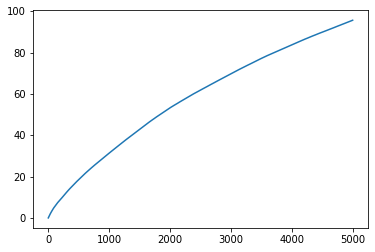

final regret: 95.62000


In [ ]:
tr = 200
num = 5000
recreation_arm_bandit(tr, num, 'e-greedy')

## 課題1
softmax 方策を実装する  
※ 上記 Agent Class を書き換えてから実行する  
※ τ=1 で良いがもっと後悔の度合いがよくなる数値があるならそれでも良い

In [ ]:
tr = 200
num = 5000
recreation_arm_bandit(tr, num, 'softmax')

arm p: 0.55
arm p: 0.45
arm p: 0.5
arm p: 0.6
trial: 200

t: 0, 

TypeError: ignored

## 課題2
UCB1方策を実装する  
※ 上記 Agent Class を書き換えてから実行する  
※ c=2 で良いがもっと後悔の度合いがよくなる数値があるならそれでも良い

In [ ]:
tr = 200
num = 5000
recreation_arm_bandit(tr, num, 'ucb1')